In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
import copy
from PIL import Image
import h5py
from matplotlib.pyplot import imshow

In [65]:
hf = h5py.File('dataHD5_Keras/train_0.h5', 'r')
hf.keys()

[u'data_1', u'data_2', u'label']

In [66]:
syn1 = hf['data_1']
syn2 = hf['data_2']
dlabel = hf['label']
syn1 = np.array(dset[:,:,:])
syn2 = np.array(dset2[:,:,:])
label = np.array(dlabel)

In [67]:
print label.shape
print syn1.shape
print syn2.shape

(2500, 27)
(2500, 64, 64, 3)
(2500, 64, 64, 3)


In [68]:
image = Image.fromarray(syn1[100].astype('uint8'))
image1 = Image.fromarray(syn2[0].astype('uint8'))
#image.save(file)
#image.show()
#image1.show()

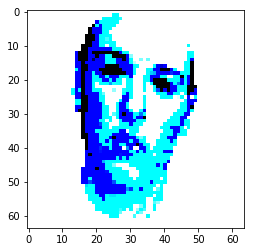

In [73]:
imshow(data[100])

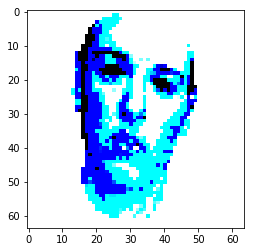

In [71]:
imshow(data2[100])

In [74]:
print label[100].shape

(27,)
